In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd


In [2]:
df = pd.read_json("results.jsonl", lines=True)
print(len(df))
df.head()

357


,id,name,params.dataset.path,params.dataset.name,params.dataset.split,params.qa.model,params.qa.temperature,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,...,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1,params.qa.technique,params.qa.n_shot
0,2eea485f9fada3ab346e4930dd791bcf69f615d2,adunc-wife,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,cte/format-relevant-few.txt,cq.txt,cte-2-shot-delim-2.json,...,0.080000,0.100619,0.16,0.204498,0.06,0.068788,0.02,0.028571,CTE,2
1,c48d065577d2b1f2c78e1e4904e70d85117a5c11,dress-puck,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,cte/format-relevant-few.txt,cq.txt,cte-2-shot-delim-2.json,...,0.090000,0.100029,0.16,0.176028,0.07,0.082726,0.04,0.041333,CTE,2
2,24d95edf9f3a0a20071cd7633221d50a6d9f2e84,moody-trug,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,cte/format-relevant-few.txt,cq.txt,cte-2-shot-delim-2.json,...,0.096667,0.114228,0.17,0.203247,0.11,0.120667,0.01,0.018769,CTE,2
3,f779879e21e0a38c23ba832c99a364f63cd0c4cd,lying-over,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,cte/format-relevant-few.txt,cq.txt,cte-2-shot-delim-1.json,...,0.180000,0.229397,0.28,0.355347,0.15,0.207989,0.11,0.124856,CTE,2
4,c348b5aec10150fdbcef567c4d15946e627a039d,sober-saga,bdsaglam/musique-mini,answerable,validation,llama-3-70b-tgi,2.0,cte/format-relevant-few.txt,cq.txt,cte-2-shot-delim-1.json,...,0.173333,0.214778,0.27,0.348005,0.19,0.212121,0.06,0.084207,CTE,2


In [3]:
param_cols = [col for col in df.columns if col.startswith("params.")]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop(
    columns=[
        "id",
        "name",
        "params.dataset.path",
        "params.dataset.name",
        "params.dataset.split",
        "params.qa.model",
    ],
    inplace=True,
)

In [25]:
target_param_cols = [
    "params.qa.technique",
    "params.qa.system_prompt",
    "params.qa.user_prompt_template",
    "params.qa.few_shot_examples",
    "params.qa.temperature",
]
df = df.sort_values(target_param_cols + ["params.run"])
df.reset_index(drop=True, inplace=True)

In [26]:
run_counts = df.groupby(target_param_cols)["params.run"].aggregate(tuple).reset_index()
mask = run_counts["params.run"].map(len) < 3
run_counts.loc[mask]

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,params.run


In [27]:
def remove_ext(filename):
    return filename.split(".", 1)[0]

df["params.qa.system_prompt"] = df["params.qa.system_prompt"].map(remove_ext)
df["params.qa.user_prompt_template"] = df["params.qa.user_prompt_template"].map(remove_ext)
df["params.qa.few_shot_examples"] = df["params.qa.few_shot_examples"].map(remove_ext)

In [29]:
df[target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False).head(10)

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
25,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.3,0.670000,0.767578,0.67,0.776727,0.75,0.821357,0.59,0.704651
6,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.640000,0.760261,0.66,0.766757,0.71,0.821516,0.55,0.692510
27,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.5,0.653333,0.757212,0.67,0.775579,0.74,0.828048,0.55,0.668009
4,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.3,0.646667,0.756386,0.66,0.773393,0.72,0.814909,0.56,0.680857
0,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.646667,0.754764,0.67,0.771598,0.73,0.821423,0.54,0.671270
1,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.643333,0.754596,0.67,0.770060,0.74,0.825888,0.52,0.667841
22,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.1,0.650000,0.753059,0.68,0.786727,0.72,0.801071,0.55,0.671381
3,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.3,0.640000,0.750212,0.67,0.771598,0.73,0.823657,0.52,0.655381
2,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.640000,0.749979,0.68,0.780060,0.72,0.809964,0.52,0.659913
29,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-2,0.5,0.633333,0.749702,0.65,0.775484,0.69,0.796582,0.56,0.677040


In [30]:
target_param_cols

['params.qa.technique',
 'params.qa.system_prompt',
 'params.qa.user_prompt_template',
 'params.qa.few_shot_examples',
 'params.qa.temperature']

In [50]:
df['params.qa.system_prompt'].unique()

array(['cte/excellent-format-few', 'cte/format-few',
       'cte/format-relevant-few', 'standard/excellent-few',
       'standard/helpful-output-format-few',
       'standard/minimal-output-format',
       'standard/minimal-output-format-few'], dtype=object)

In [40]:
avg_df = df.groupby(target_param_cols)[metric_cols].mean().reset_index()
avg_df.head()

,params.qa.technique,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,params.qa.temperature,metrics.exact_match,metrics.f1,metrics.2hops.exact_match,metrics.2hops.f1,metrics.3hops.exact_match,metrics.3hops.f1,metrics.4hops.exact_match,metrics.4hops.f1
0,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.1,0.643333,0.753113,0.673333,0.773906,0.730000,0.819092,0.526667,0.666341
1,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.3,0.638889,0.746529,0.670000,0.775017,0.716667,0.813487,0.530000,0.651083
2,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.5,0.634444,0.745949,0.660000,0.767224,0.713333,0.810331,0.530000,0.660292
3,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,0.7,0.624444,0.739925,0.646667,0.758482,0.703333,0.809833,0.523333,0.651462
4,CTE,cte/excellent-format-few,cq,cte-2-shot-delim-1,1.0,0.620000,0.734032,0.643333,0.760048,0.680000,0.782867,0.536667,0.659183


In [47]:
from functools import reduce

# find the rows with max f1 score for each technique group
max_f1_rows = avg_df.groupby('params.qa.technique')["metrics.f1"].idxmax()
best_df = avg_df.loc[max_f1_rows, target_param_cols + metric_cols].sort_values('metrics.f1', ascending=False)

records = best_df[target_param_cols].to_dict(orient='records')
records


best_records_per_technique = []
for record in records:
    masks = []
    for key, value in record.items():
        masks.append(df[key] == value)
    # take and of all the masks
    final_mask = reduce(lambda x, y: x & y, masks)
    best_records_per_technique.extend(df.loc[final_mask].to_dict(orient='records'))

best_records_per_technique[0]

{'params.qa.temperature': 0.1,
 'params.qa.system_prompt': 'cte/excellent-format-few',
 'params.qa.user_prompt_template': 'cq',
 'params.qa.few_shot_examples': 'cte-2-shot-delim-1',
 'params.run': 1,
 'metrics.exact_match': 0.6466666667000001,
 'metrics.f1': 0.7547638405,
 'metrics.2hops.exact_match': 0.67,
 'metrics.2hops.f1': 0.7715983037,
 'metrics.3hops.exact_match': 0.73,
 'metrics.3hops.f1': 0.8214233766,
 'metrics.4hops.exact_match': 0.54,
 'metrics.4hops.f1': 0.6712698413,
 'params.qa.technique': 'CTE',
 'params.qa.n_shot': 2}

## Statistical Testing

In [51]:
def prepare_data_for_anova(dataf):
    metric_column = "metrics.f1"

    if dataf.empty:
        raise ValueError("No data available")

    # Simplify column names for use in formula
    dataf = dataf.rename(
        columns={
            "params.qa.temperature": "temperature",
            "params.qa.system_prompt": "system_prompt",
            "params.qa.user_prompt_template": "user_prompt",
            "params.qa.few_shot_examples": "few_shot_examples",
            "params.qa.n_shot": "n_shot",
        }
    )

    # Combine prompts into a single column for simplicity
    dataf["prompt"] = (
        dataf["system_prompt"]
        + " | "
        + dataf["user_prompt"]
        + " | "
        + dataf["few_shot_examples"].map(str)
    )

    return dataf[["temperature", "prompt", "params.run", metric_column]].rename(
        columns={metric_column: "f1"}
    )


def two_way_anova(dataf):
    # Perform Two-Way ANOVA with replication
    formula = "f1 ~ C(prompt) + C(temperature) + C(prompt):C(temperature)"
    model = ols(formula, data=dataf).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print("Two-Way ANOVA Results:")
    print(anova_table)


def one_way_anova_by_temperature(dataf):
    # Perform One-Way ANOVA at each temperature
    temperatures = dataf["temperature"].unique()
    for temp in temperatures:
        temp_data = dataf[dataf["temperature"] == temp]
        grouped = temp_data.groupby("prompt")["f1"].apply(list).reset_index()
        f1_scores = grouped["f1"]

        if len(f1_scores) < 2:
            print(f"Skipping temperature {temp}: Not enough groups to perform ANOVA")
            continue

        anova_result = f_oneway(*f1_scores)
        print(f"One-Way ANOVA for Temperature {temp:.1f}:")
        print(
            f"F-statistic: {anova_result.statistic:.4f}, p-value: {anova_result.pvalue:.4e}"
        )


def visualize_results(dataf):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x="temperature", y="f1", hue="prompt", data=dataf)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    plt.legend(title="Prompt", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


prepared_data = prepare_data_for_anova(df)
prepared_data.head()


,temperature,prompt,params.run,f1
0,0.1,cte/excellent-format-few | cq | cte-2-shot-del...,1,0.754764
1,0.1,cte/excellent-format-few | cq | cte-2-shot-del...,2,0.754596
2,0.1,cte/excellent-format-few | cq | cte-2-shot-del...,3,0.749979
3,0.3,cte/excellent-format-few | cq | cte-2-shot-del...,1,0.750212
4,0.3,cte/excellent-format-few | cq | cte-2-shot-del...,2,0.756386


In [52]:
# Two-Way ANOVA
two_way_anova(prepared_data)

Two-Way ANOVA Results:
                            sum_sq     df             F         PR(>F)
C(prompt)                 0.405759   16.0    208.210414  5.927135e-130
C(temperature)            9.194971    6.0  12582.095774  1.090446e-294
C(prompt):C(temperature)  1.032536   96.0     88.305509  1.425824e-145
Residual                  0.028988  238.0           NaN            NaN


In [53]:
# Perform One-Way ANOVA by Temperature
one_way_anova_by_temperature(prepared_data)

One-Way ANOVA for Temperature 0.1:
F-statistic: 222.9350, p-value: 1.2246e-29
One-Way ANOVA for Temperature 0.3:
F-statistic: 113.3392, p-value: 9.7591e-25
One-Way ANOVA for Temperature 0.5:
F-statistic: 49.7982, p-value: 6.6584e-19
One-Way ANOVA for Temperature 0.7:
F-statistic: 53.2429, p-value: 2.2736e-19
One-Way ANOVA for Temperature 1.0:
F-statistic: 52.7195, p-value: 2.6653e-19
One-Way ANOVA for Temperature 1.5:
F-statistic: 47.7447, p-value: 1.3069e-18
One-Way ANOVA for Temperature 2.0:
F-statistic: 159.2099, p-value: 3.4267e-27


In [54]:
# Tukey’s HSD
temperature_mask = prepared_data['temperature'] <= 1.0
_data = prepared_data.loc[temperature_mask]
tukey = pairwise_tukeyhsd(endog=_data['f1'], groups=_data['prompt'], alpha=0.05)
print(tukey)


                                                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                    
                          group1                                                    group2                          meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------------------------------------------------------------------
       cte/excellent-format-few | cq | cte-2-shot-delim-1        cte/excellent-format-few | cq | cte-2-shot-delim-2   0.0016    1.0 -0.0103  0.0135  False
       cte/excellent-format-few | cq | cte-2-shot-delim-1                     cte/excellent-format-few | cq | empty  -0.0838    0.0 -0.0957 -0.0719   True
       cte/excellent-format-few | cq | cte-2-shot-delim-1                  cte/format-few | cq | cte-2-shot-delim-1  -0.0079 0.6426 -0.0198   0.004  False
       cte/excellent-format-few | cq | cte-2-shot-delim-1             

In [55]:
# Tukey’s HSD
temperature_mask = prepared_data['temperature'] <= 1.0
zero_shot_mask = prepared_data['prompt'].str.contains('empty')
_data = prepared_data.loc[temperature_mask&~zero_shot_mask]
tukey = pairwise_tukeyhsd(endog=_data['f1'], groups=_data['prompt'], alpha=0.005)
print(tukey)


                                                   Multiple Comparison of Means - Tukey HSD, FWER=0.01                                                    
                          group1                                                    group2                          meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------------------------------------------------------------------------------
       cte/excellent-format-few | cq | cte-2-shot-delim-1        cte/excellent-format-few | cq | cte-2-shot-delim-2   0.0016    1.0 -0.0109   0.014  False
       cte/excellent-format-few | cq | cte-2-shot-delim-1                  cte/format-few | cq | cte-2-shot-delim-1  -0.0079 0.2787 -0.0203  0.0045  False
       cte/excellent-format-few | cq | cte-2-shot-delim-1                  cte/format-few | cq | cte-2-shot-delim-2  -0.0084  0.206 -0.0208  0.0041  False
       cte/excellent-format-few | cq | cte-2-shot-delim-1         cte/

In [71]:
best_prepared_data_per_technique = prepare_data_for_anova(pd.DataFrame(best_records_per_technique))
best_prepared_data_per_technique

,temperature,prompt,params.run,f1
0,0.1,cte/excellent-format-few | cq | cte-2-shot-del...,1,0.754764
1,0.1,cte/excellent-format-few | cq | cte-2-shot-del...,2,0.754596
2,0.1,cte/excellent-format-few | cq | cte-2-shot-del...,3,0.749979
3,0.1,standard/helpful-output-format-few | cq | stan...,1,0.696761
4,0.1,standard/helpful-output-format-few | cq | stan...,2,0.705030
5,0.1,standard/helpful-output-format-few | cq | stan...,3,0.700252


In [73]:
# Perform One-Way ANOVA by Temperature
one_way_anova_by_temperature(best_prepared_data_per_technique)

One-Way ANOVA for Temperature 0.1:
F-statistic: 335.2102, p-value: 5.2351e-05


In [74]:
# Tukey’s HSD
tukey = pairwise_tukeyhsd(endog=best_prepared_data_per_technique['f1'], groups=best_prepared_data_per_technique['prompt'], alpha=0.005)
print(tukey)


                                                Multiple Comparison of Means - Tukey HSD, FWER=0.01                                                
                      group1                                                 group2                          meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------------------------------------------------------------------
cte/excellent-format-few | cq | cte-2-shot-delim-1 standard/helpful-output-format-few | cq | standard-2-shot  -0.0524 0.0001 -0.0685 -0.0364   True
---------------------------------------------------------------------------------------------------------------------------------------------------


## Visualizations

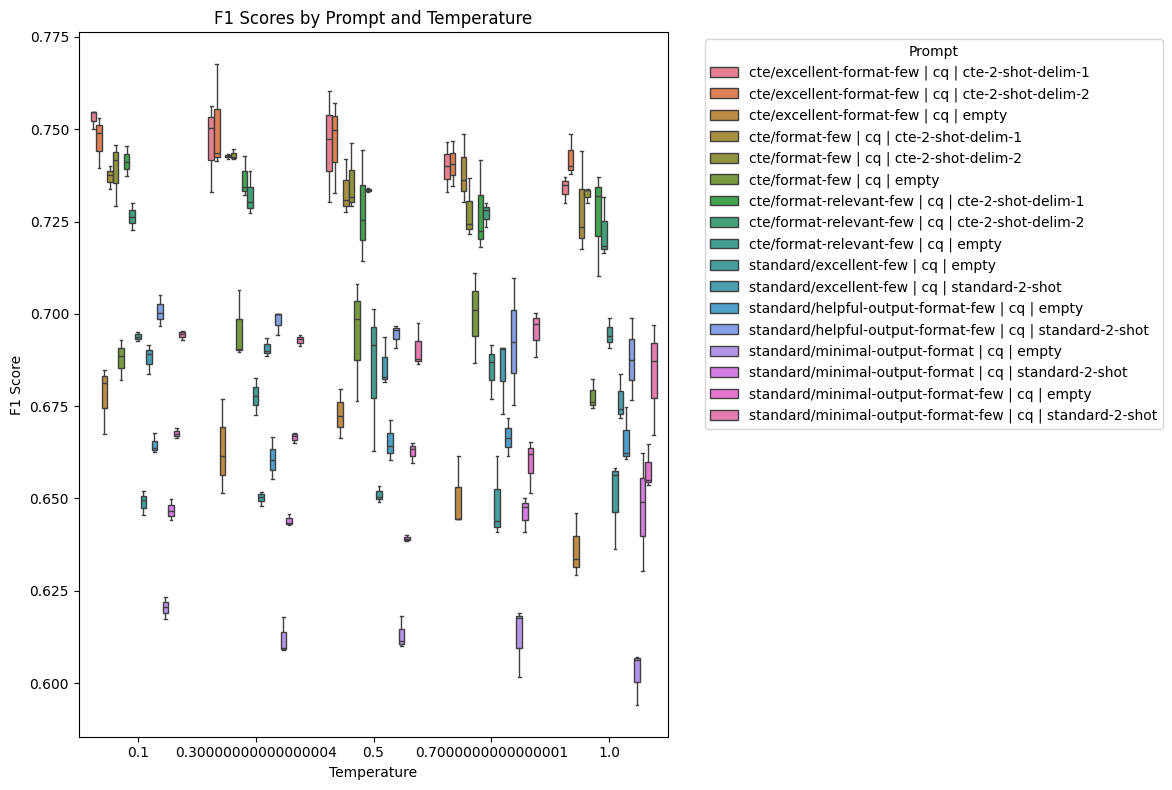

In [57]:
# Visualize Results
temperature_mask = prepared_data['temperature'] <= 1.0
visualize_results(prepared_data.loc[temperature_mask])


In [58]:
def plot_variance(dataf, figsize=(8, 8), legend_loc='lower left'):
    plt.figure(figsize=figsize)
    sns.lineplot(x='temperature', y='f1', hue='prompt', data=dataf, linewidth=2.5)
    plt.title("F1 Scores by Prompt and Temperature")
    plt.xlabel("Temperature")
    plt.ylabel("F1 Score")
    plt.legend(title="Prompt", loc=legend_loc)
    plt.tight_layout()
    plt.show()

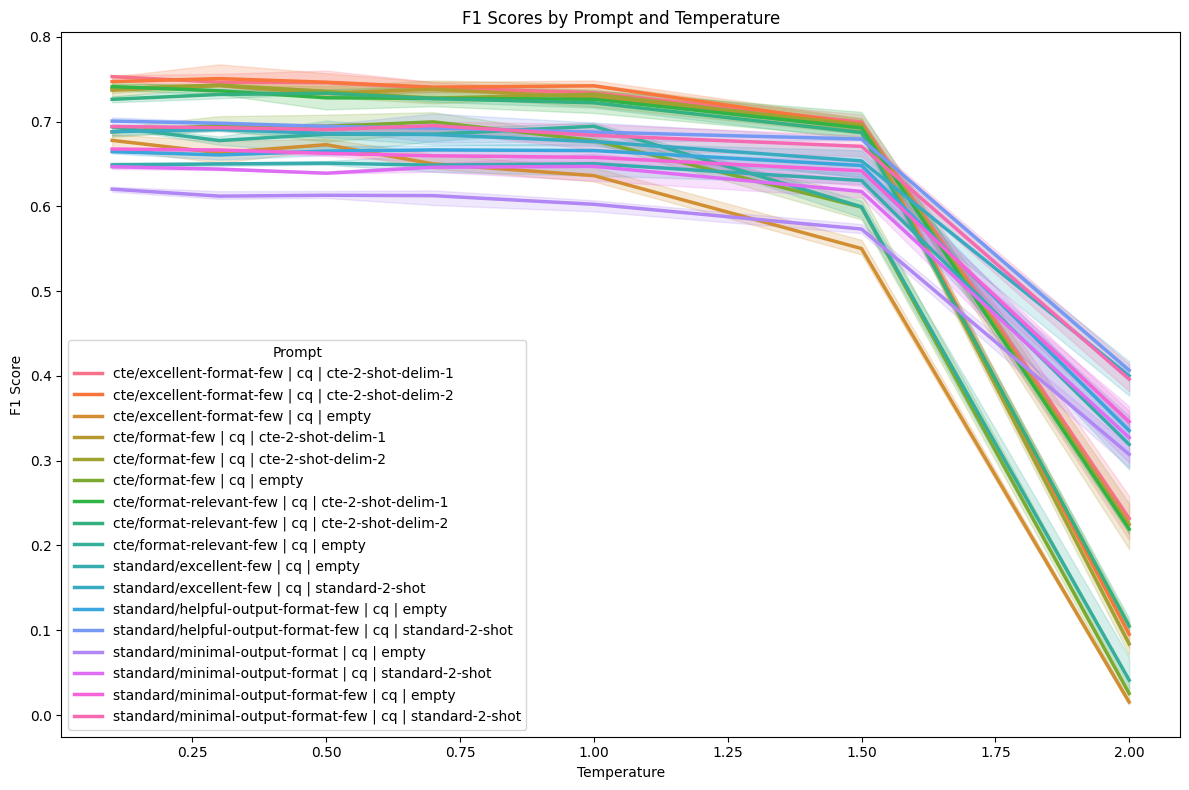

In [59]:
plot_variance(prepared_data, figsize=(12, 8))

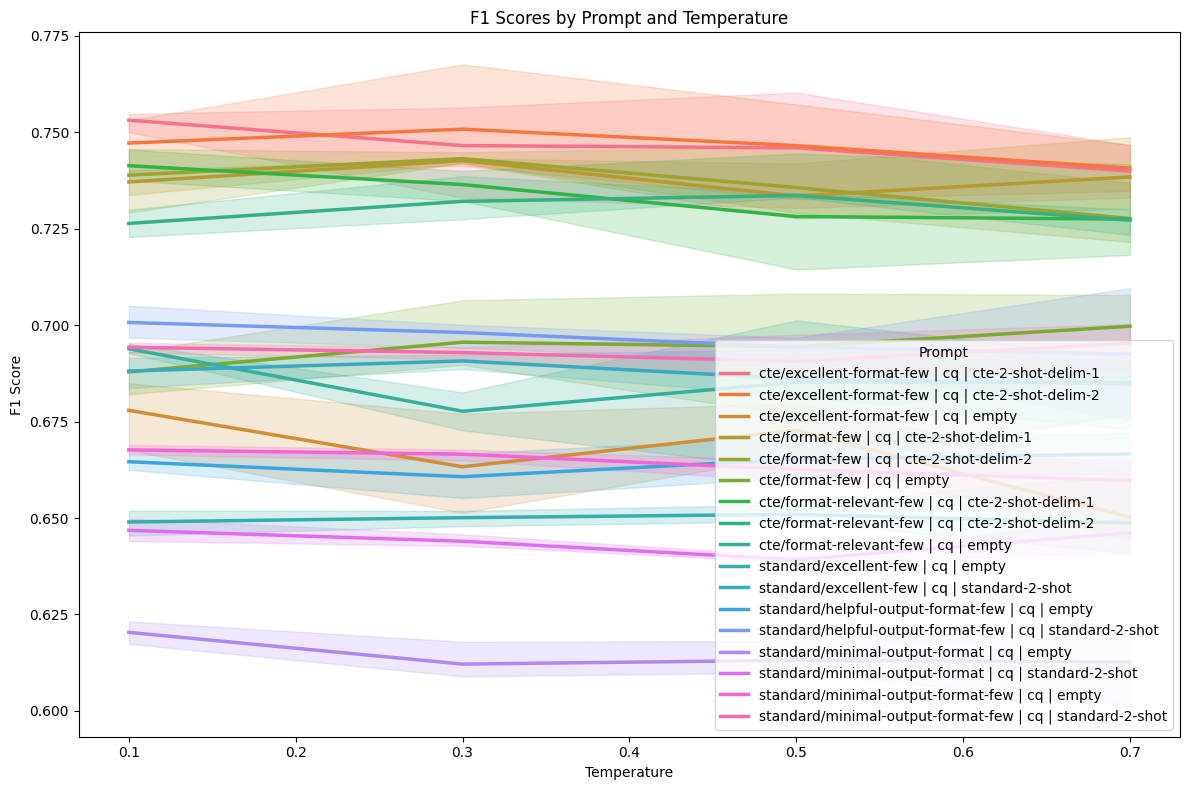

In [60]:
temperature_mask = prepared_data['temperature'] < 1.0
plot_variance(prepared_data.loc[temperature_mask], figsize=(12, 8), legend_loc='lower right')

In [61]:
temperature_mask = prepared_data["temperature"] <= 1.0
prompt_f1 = prepared_data.loc[temperature_mask].groupby(["prompt"])["f1"].describe()
prompt_f1.sort_values(by="mean", ascending=False, inplace=True)
prompt_f1

,count,mean,std,min,25%,50%,75%,max
prompt,,,,,,,,
cte/excellent-format-few | cq | cte-2-shot-delim-2,15.0,0.745473,0.009158,0.732629,0.739741,0.743459,0.749404,0.767578
cte/excellent-format-few | cq | cte-2-shot-delim-1,15.0,0.743910,0.010366,0.730133,0.733979,0.746669,0.752404,0.760261
cte/format-few | cq | cte-2-shot-delim-1,15.0,0.736019,0.008616,0.717681,0.730529,0.737482,0.742348,0.748715
cte/format-few | cq | cte-2-shot-delim-2,15.0,0.735547,0.007964,0.721547,0.729589,0.733898,0.742332,0.746196
cte/format-relevant-few | cq | cte-2-shot-delim-1,15.0,0.731943,0.011329,0.710163,0.724035,0.734431,0.741360,0.745507
cte/format-relevant-few | cq | cte-2-shot-delim-2,15.0,0.728285,0.006006,0.716525,0.724853,0.729905,0.732390,0.738597
standard/helpful-output-format-few | cq | standard-2-shot,15.0,0.694645,0.009330,0.675305,0.691572,0.696686,0.700057,0.709593
standard/minimal-output-format-few | cq | standard-2-shot,15.0,0.691380,0.007884,0.667196,0.688156,0.693228,0.696250,0.700268
cte/format-few | cq | empty,15.0,0.691047,0.011905,0.674583,0.682207,0.689706,0.699861,0.711174


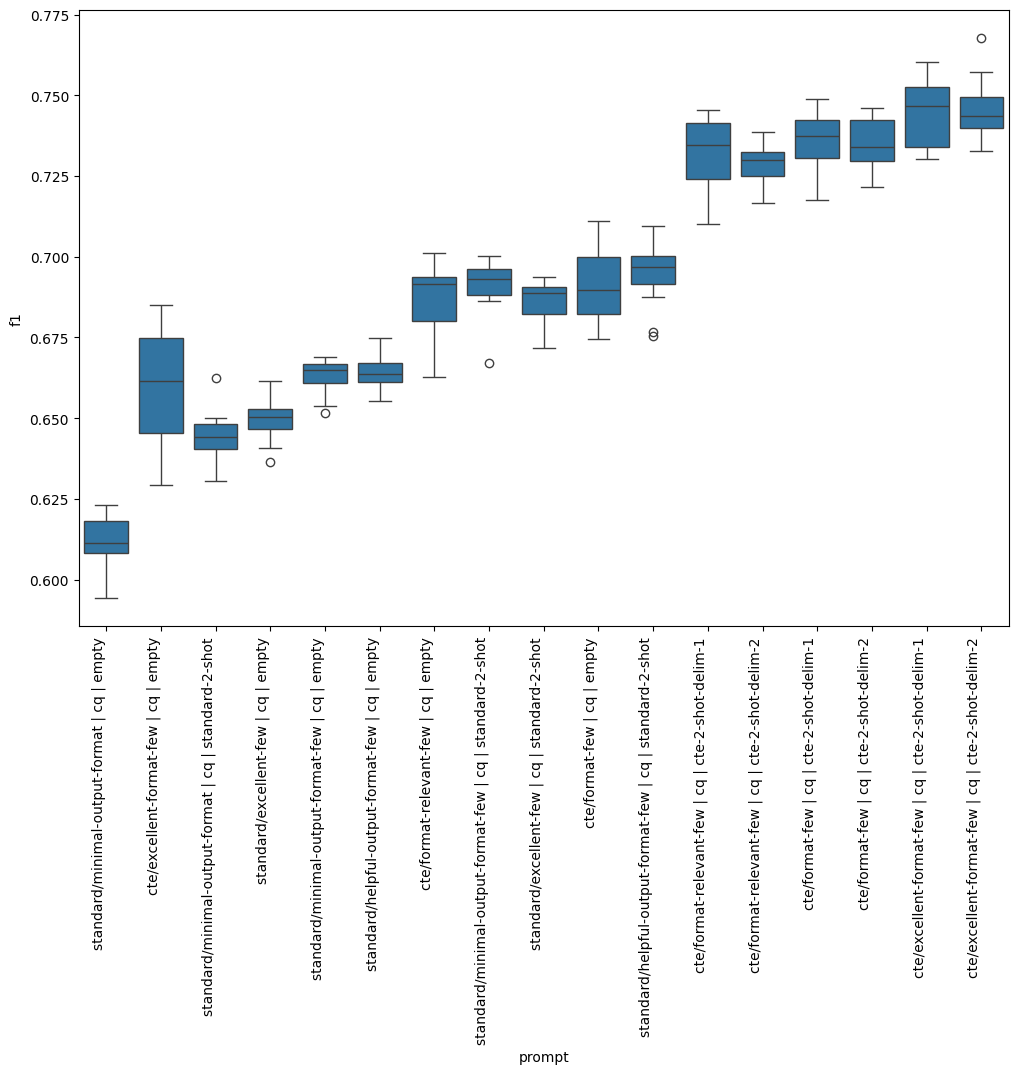

In [63]:
# box-whisker plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x="prompt",
    y="f1",
    data=prepared_data.loc[temperature_mask].sort_values(by="f1"),
)
plt.xticks(rotation=90, ha="right");